In [1]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

# Data

In [2]:
training = pd.read_csv('Data/TrainingWiDS2021.csv', index_col=0)

In [3]:
test = pd.read_csv('Data/UnlabeledWiDS2021.csv', index_col=0)

In [4]:
train_is_positive = training['diabetes_mellitus']==1
train_is_negative = ~train_is_positive

# Analysis

## Helpers

In [5]:
def hist_by_diagnosis(feature):
    x = training[feature]
    plt.hist([x[train_is_positive], x[train_is_negative]])
    plt.title(f'Distribution of Diagnosis by {feature}')
    plt.legend(["+", "-"])

## Age

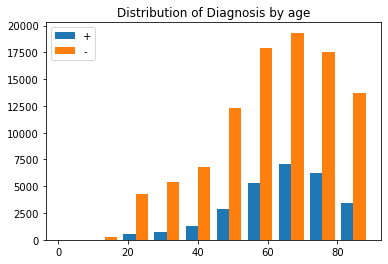

In [6]:
hist_by_diagnosis('age')

# Prediction

## Helpers

In [7]:
import sklearn.linear_model as lm
import sklearn.neighbors as nb
import sklearn.tree as tree
import sklearn.preprocessing as pp

In [8]:
def balance_training():
    has_diabetes = training[train_is_positive].sample(25000)
    no_diabetes = training[train_is_negative].sample(25000)
    return pd.concat([has_diabetes,no_diabetes])

In [9]:
def fillna(dtype, val):
    selected_cols = [col for col in training.columns if training[col].dtype == dtype]
    for col in selected_cols:
        training[col] = training[col].fillna(val)
        if col in test:
            test[col] = test[col].fillna(val)

In [10]:
def encode(column):
    global training
    global test
    all_data = pd.concat([training[[column]], test[[column]]])
    encoder = pp.OneHotEncoder()
    encoder.fit(all_data)
    columns = [column + ": " + category for category in encoder.categories_[0]]
    def apply(df):
        encodings = encoder.transform(df[[column]]).toarray()
        encodings_df = pd.DataFrame(encodings, columns=columns, index=df.index)
        df = df.join(encodings_df)
        return df.drop(columns=column)
    training = apply(training)
    test = apply(test)

In [11]:
def execute(classifier, features):
    classifier.fit(training[features], training['diabetes_mellitus'])
    test['diabetes_mellitus']=classifier.predict(test[features])
    write_solution(test)
    return classifier

In [12]:
def write_solution(solution):
    results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
    results.to_csv('Data/results.csv')

## Data Preparation

In [13]:
training = balance_training()

In [14]:
training['bmi'] = pd.to_numeric(training['bmi'])
test['bmi'] = pd.to_numeric(test['bmi'])

In [15]:
training['age'] = training['age'].fillna(0)

In [16]:
training['bmi'] = training['bmi'].fillna(0)
test['bmi'] = test['bmi'].fillna(0)

In [17]:
training['glucose_apache'] = training['glucose_apache'].fillna(0)
test['glucose_apache'] = test['glucose_apache'].fillna(0)

In [18]:
training['ethnicity'] = training['ethnicity'].fillna("Other/Unknown")
test['ethnicity'] = test['ethnicity'].fillna("Other/Unknown")

In [19]:
fillna('O', "Other")

In [20]:
fillna('int64', 0)
fillna('float64', 0)

In [21]:
for col in test.columns:
    if training[col].dtype == 'O':
        encode(col)

## Diagnosis = 0

In [22]:
solution = pd.read_csv('Data/SolutionTemplateWiDS2021.csv', index_col=0)

In [23]:
test['diabetes_mellitus'] = 0

In [24]:
write_solution(test)

## Diagnosis = elective_surgery

In [25]:
test['diabetes_mellitus'] = test['elective_surgery']

In [26]:
write_solution(test)

## Age logistic regression

In [27]:
clf = execute(lm.LogisticRegression(), ['age'])

In [28]:
X_test = np.linspace(0,100,300)

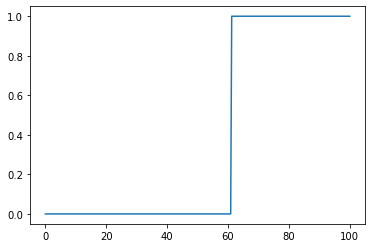

In [29]:
plt.plot(X_test, clf.predict(X_test[:,None]));

## Age + BMI logistic regression

In [30]:
execute(lm.LogisticRegression(), ['age', 'bmi']);

## Age + BMI kNN classifier

In [31]:
execute(nb.KNeighborsClassifier(), ['age','bmi']);

## Age, BMI, Glucose Apache kNN

In [32]:
execute(nb.KNeighborsClassifier(), ['age','bmi','glucose_apache']);

## Age, BMI, Glucose Apache logistic regression

In [33]:
execute(lm.LogisticRegression(), ['age','bmi','glucose_apache']);

## Decision Tree

In [34]:
execute(tree.DecisionTreeClassifier(), ['age','bmi','glucose_apache']);

## Logistic Regression all features

In [35]:
clf = execute(lm.LogisticRegression(), test.columns);

C:\Users\jachea\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Miscellaneous

In [36]:
test.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight',
       ...
       'icu_stay_type: transfer', 'icu_type: CCU-CTICU', 'icu_type: CSICU',
       'icu_type: CTICU', 'icu_type: Cardiac ICU', 'icu_type: MICU',
       'icu_type: Med-Surg ICU', 'icu_type: Neuro ICU', 'icu_type: SICU',
       'diabetes_mellitus'],
      dtype='object', length=215)

In [37]:
import sklearn.feature_selection as fs

In [38]:
training_chi = fs.SelectKBest(fs.chi2, k=20).fit_transform(training.drop(columns=['diabetes_mellitus']), training['diabetes_mellitus'])

ValueError: Input X must be non-negative.

In [57]:
list((training < 0).any())

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 

In [62]:
[x for x in list(training[training.columns[7]]) if x < 0]

[-0.055555556,
 -0.038194444,
 -0.0048611109999999996,
 -0.009722221999999999,
 -0.028472222000000002,
 -0.00625,
 -0.124305556,
 -0.04236111099999999,
 -0.00625,
 -0.211805556,
 -0.127777778,
 -0.019444443999999998,
 -0.019444443999999998,
 -0.09652777800000001,
 -0.005555556,
 -0.050694444000000005,
 -0.029166667,
 -0.054166667,
 -0.143055556,
 -0.008333333,
 -0.006944444,
 -0.025,
 -0.034027778,
 -0.059027777999999996,
 -0.0020833329999999997,
 -0.010416667,
 -0.06875,
 -0.065972222,
 -0.022222222000000003,
 -0.05,
 -0.019444443999999998,
 -0.013888889,
 -0.11597222199999999,
 -0.120833333,
 -0.0048611109999999996,
 -0.20694444399999998,
 -0.032638889,
 -0.123611111,
 -0.07777777799999999,
 -0.141666667,
 -0.007638889,
 -0.035416667,
 -0.201388889,
 -0.013194444,
 -0.011111111000000002,
 -0.060416667,
 -0.010416667,
 -0.088888889,
 -0.007638889,
 -0.105555556,
 -0.0048611109999999996,
 -0.006944444,
 -0.047916667,
 -0.015972222,
 -0.0375,
 -0.007638889,
 -0.013888889,
 -0.0020833329

In [63]:
training.columns[7]

'pre_icu_los_days'

In [39]:
training.drop(columns=['diabetes_mellitus'])

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,...,icu_stay_type: readmit,icu_stay_type: transfer,icu_type: CCU-CTICU,icu_type: CSICU,icu_type: CTICU,icu_type: Cardiac ICU,icu_type: MICU,icu_type: Med-Surg ICU,icu_type: Neuro ICU,icu_type: SICU
96137,179367,131,68.0,23.992947,0,165.1,979,0.118056,0,65.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
84551,152664,188,62.0,33.528593,0,172.7,840,0.052083,0,100.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
52809,201443,27,43.0,23.673469,0,175.0,608,0.397222,0,72.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
81690,162650,18,33.0,66.059032,1,175.3,775,0.293056,0,186.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
109197,212889,154,57.0,42.302225,0,154.9,1020,0.247222,0,101.50,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113868,183223,86,55.0,42.122449,1,175.0,1035,5.956944,0,129.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90383,237535,195,85.0,67.814990,0,137.2,908,0.113194,0,73.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
588,158338,118,19.0,18.761285,0,167.6,114,0.002083,0,52.70,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114970,159494,86,49.0,23.983008,0,175.3,1032,0.179167,0,73.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [44]:
x = training[["encounter_id"]].fillna(0)

,encounter_id
96137,NaN
84551,NaN
52809,NaN
81690,NaN
109197,NaN
...,...
113868,NaN
90383,NaN
588,NaN
114970,NaN


,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,...,icu_stay_type: readmit,icu_stay_type: transfer,icu_type: CCU-CTICU,icu_type: CSICU,icu_type: CTICU,icu_type: Cardiac ICU,icu_type: MICU,icu_type: Med-Surg ICU,icu_type: Neuro ICU,icu_type: SICU
96137,179367,131,68.0,23.992947,0,165.1,979,0.118056,0,65.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
84551,152664,188,62.0,33.528593,0,172.7,840,0.052083,0,100.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
52809,201443,27,43.0,23.673469,0,175.0,608,0.397222,0,72.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
81690,162650,18,33.0,66.059032,1,175.3,775,0.293056,0,186.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
109197,212889,154,57.0,42.302225,0,154.9,1020,0.247222,0,101.50,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113868,183223,86,55.0,42.122449,1,175.0,1035,5.956944,0,129.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90383,237535,195,85.0,67.814990,0,137.2,908,0.113194,0,73.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
588,158338,118,19.0,18.761285,0,167.6,114,0.002083,0,52.70,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114970,159494,86,49.0,23.983008,0,175.3,1032,0.179167,0,73.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


TODO: pre_icu_los_days has negative values, so we can't use chi-squared. Either pick a different statistic for feature_selection, or convert negative values to 0.